In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import os
from helpers.plot_helpers import *
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import holoviews as hv
hvplot.output(widget_location='bottom')

# Function for plotting comparison

In [2]:
# We compare masked fields because outside there may be 1e+20 values
def compare(online, offline, mask, zl=-1, vmax=None):
    default_rcParams({'font.size':30})
    plt.figure(figsize=(20,12))
    plt.subplot(1,3,1)
    (online*mask).isel(zl=zl).plot(vmax=vmax, robust=True)
    plt.xlabel(''); plt.ylabel('')
    plt.title('online')
    plt.subplot(1,3,2)
    (offline*mask).isel(zl=zl).plot(vmax=vmax, robust=True)
    plt.title('offline')
    plt.xlabel(''); plt.ylabel('')
    plt.subplot(1,3,3)
    np.abs((online-offline)*mask).isel(zl=zl).plot(vmax=vmax, robust=True)
    plt.title('difference')
    plt.xlabel(''); plt.ylabel('')
    plt.tight_layout()
    error = np.abs(((online-offline)*mask)).mean() / np.abs(offline*mask).mean()
    print('Relative Error:', float((error**2).sum()))
    print('Nans:', int(np.sum(np.isnan(error))))

# Check a single function

In [3]:
import xgcm ;xgcm.__version__

'0.8.1'

In [14]:
from xgcm import Grid
def check_nans(x, message):
    if np.isnan(x).sum() > 0:
        print('NaNs in ', message)
def Zanna_Bolton(mom,param,Stress_iter=0,R_diss=-1,HPF_iter=0, ZB_type=0, ZB_cons=0, k_bc=-1, amplitude=1, Txy_only=False, double_counting=True):
    grid = Grid(param, coords={
                'X': {'center': 'xh', 'outer': 'xq'},
                'Y': {'center': 'yh', 'outer': 'yq'}
                },
                boundary={'X':'periodic', 'Y':'fill'},
                fill_value = {'X':1e+20, 'Y':1e+20}
                )
    check_nans(mom.u, 'u')
    check_nans(mom.u, 'v')
    
    dudx = grid.diff(mom.u * param.wet_u / param.dyCu, 'X') * param.dyT / param.dxT
    dvdy = grid.diff(mom.v * param.wet_v / param.dxCv, 'Y') * param.dxT / param.dyT
    
    dudy = grid.diff(mom.u / param.dxCu, 'Y') * param.dxBu / param.dyBu * param.wet_c
    dvdx = grid.diff(mom.v / param.dyCv, 'X') * param.dyBu / param.dxBu * param.wet_c
    
    check_nans(dudx, 'dudx')
    check_nans(dvdy, 'dvdy')
    check_nans(dudy, 'dudy')
    check_nans(dudx, 'dudx')
    
    sh_xx = dudx-dvdy
    sh_xy = dvdx+dudy
    vort_xy=dvdx-dudy
    
    if R_diss > 0:
        shear = np.sqrt(sh_xx**2 + grid.interp(sh_xy**2 + vort_xy**2, ['X', 'Y']))
        coriolis = np.abs(
                grid.interp(param.Coriolis, ['X', 'Y'])
                ) + 1e-30
        c_diss = 1 / (1 + shear / (coriolis * R_diss) )
    else:
        c_diss = sh_xx*0 + 1
    
    if HPF_iter > 0:
        sh_xx0 = sh_xx.copy()
        sh_xy0 = sh_xy.copy()
        vort_xy0 = vort_xy.copy()
        for i in range(HPF_iter):
            sh_xx = param.wet * filter_apply(sh_xx * param.wet, x_periodic=True)
            sh_xy = param.wet_c * filter_apply(sh_xy * param.wet_c,x_periodic=True)
            vort_xy = param.wet_c * filter_apply(vort_xy * param.wet_c,x_periodic=True)
        sh_xx = sh_xx0 - sh_xx
        sh_xy = sh_xy0 - sh_xy
        vort_xy = vort_xy0 - vort_xy
    
    vort_xy_center = grid.interp(vort_xy,['X','Y'])
    sh_xy_center = grid.interp(sh_xy,['X','Y'])
    sh_xx_corner = grid.interp(sh_xx,['X', 'Y']) * param.wet_c
    
    if (ZB_cons == 0):
        vort_sh = vort_xy_center * sh_xy_center
    elif (ZB_cons == 1):
        vort_sh = grid.interp(param.area_q * vort_xy * sh_xy, ["X", "Y"]) / (param.area_t+1e-70)
    elif (ZB_cons == 2):
        vort_sh = grid.interp(vort_xy * sh_xy, ["X", "Y"])
    elif (ZB_cons == 3):
        vort_sh = grid.interp(param.area_q**2 * vort_xy * sh_xy, ["X", "Y"]) / (param.area_t**2+1e-70)
    else:
        print('Error: wrong ZB_cons')
        
    sum_sq = 0.5 * (vort_xy_center**2 + sh_xy_center**2 + sh_xx**2)
    if (ZB_type == 1):
        sum_sq = 0 * sum_sq
    if (ZB_type == 2):
        vort_sh = 0 * vort_sh
        
    if k_bc<0:
        kappa_t = param.area_t * param.wet * amplitude
        kappa_q = param.area_q * param.wet_c * amplitude
    else:
        kappa_t = k_bc * param.wet
        kappa_q = k_bc * param.wet_c
        
        
    Txx = - kappa_t * (- vort_sh + sum_sq)
    Tyy = - kappa_t * (+ vort_sh + sum_sq)
    Txy = - kappa_q * (vort_xy * sh_xx_corner)
    
    if Txy_only:
        Txx = Txx * 0
        Tyy = Tyy * 0
    
    if (ZB_type == 2):
        Txy = Txy * 0
    
    h_u = grid.interp(mom.h * param.wet, 'X')
    h_v = grid.interp(mom.h * param.wet, 'Y')

    from xgcm.grid_ufunc import as_grid_ufunc
    @as_grid_ufunc(signature="(X:center)->(X:outer)", boundary_width={'X':(1,1)})
    def prod_ufunc(a):
        return a[...,:-1] * a[...,1:]
    
    h2uq = 4.0 * prod_ufunc(grid, h_u, axis='Y') #prod_u_Y(h_u)
    h2vq = 4.0 * prod_ufunc(grid, h_v, axis='X')#prod_v_X(h_v)
    h_neglect3 = 1e-70
    hq = (2 * h2uq * h2vq) / (h_neglect3 + (h2uq+h2vq) * 2 * (grid.interp(h_u,'Y') + grid.interp(h_v,'X')))
    
    for i in range(Stress_iter):
        Txx = param.wet * filter_apply(Txx * param.wet, x_periodic=True)
        Tyy = param.wet * filter_apply(Tyy * param.wet, x_periodic=True)
        Txy = param.wet_c * filter_apply(Txy * param.wet_c,x_periodic=True)

    TTxx = Txx * mom.h * c_diss
    TTyy = Tyy * mom.h * c_diss
    TTxy = Txy * hq * grid.interp(c_diss, ['X', 'Y'])
    
    ZB2020u = (grid.diff(TTxx*param.dyT**2, 'X') / param.dyCu     \
           + grid.diff(TTxy*param.dxBu**2, 'Y') / param.dxCu) \
           / (param.dxCu*param.dyCu) / (h_u+1e-70)

    ZB2020v = (grid.diff(TTxy*param.dyBu**2, 'X') / param.dyCv     \
               + grid.diff(TTyy*param.dxT**2, 'Y') / param.dxCv) \
               / (param.dxCv*param.dyCv) / (h_v+1e-70)
    
    KE_source = (grid.interp(param.wet_u * mom.u * h_u * param.area_u * ZB2020u, "X") + \
                 grid.interp(param.wet_v * mom.v * h_v * param.area_v * ZB2020v, "Y")) * param.wet
    
    Px_source = param.wet_u * h_u * param.area_u * ZB2020u
    Py_source = param.wet_v * h_v * param.area_v * ZB2020v
    if not double_counting:
        Px_source[{'xq':0}] = 0 # This is repeating point due to B.C.
    
    return {'ZB2020u': ZB2020u, 'ZB2020v': ZB2020v, 
            'Txx': Txx, 'Tyy': Tyy, 'Txy': Txy, 
            'TTxx': TTxx, 'TTyy': TTyy, 'TTxy': TTxy, 
            'c_diss': c_diss, 
            'sh_xx': sh_xx, 'sh_xy': sh_xy, 'vort_xy': vort_xy,
            'hq' : hq, 'KE_source': KE_source, 
            'Px_source': Px_source, 'Py_source': Py_source}

# Padding

In [5]:
folder = '/scratch/pp2681/mom6/regression_tests/profiling-NW2'
param = xr.open_dataset(f'{folder}/ocean_geometry.nc').rename({'lonq': 'xq', 'latq': 'yq', 'lonh': 'xh', 'lath': 'yh'})
static = xr.open_dataset(f'{folder}/static.nc', decode_times=False)
param = xr.merge([param, static])
mom = xr.open_dataset(f'{folder}/mom_00030001.nc', decode_times=False).squeeze()
for key in mom.variables:
    mom[key] = mom[key].fillna(1e+20)

In [12]:
grid = Grid(param, coords={
            'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'}
            },
           boundary={"X": 'fill', 'Y': 'fill'},
           fill_value=1e+20)

Relative Error: 0.002279769790101001
Nans: 0


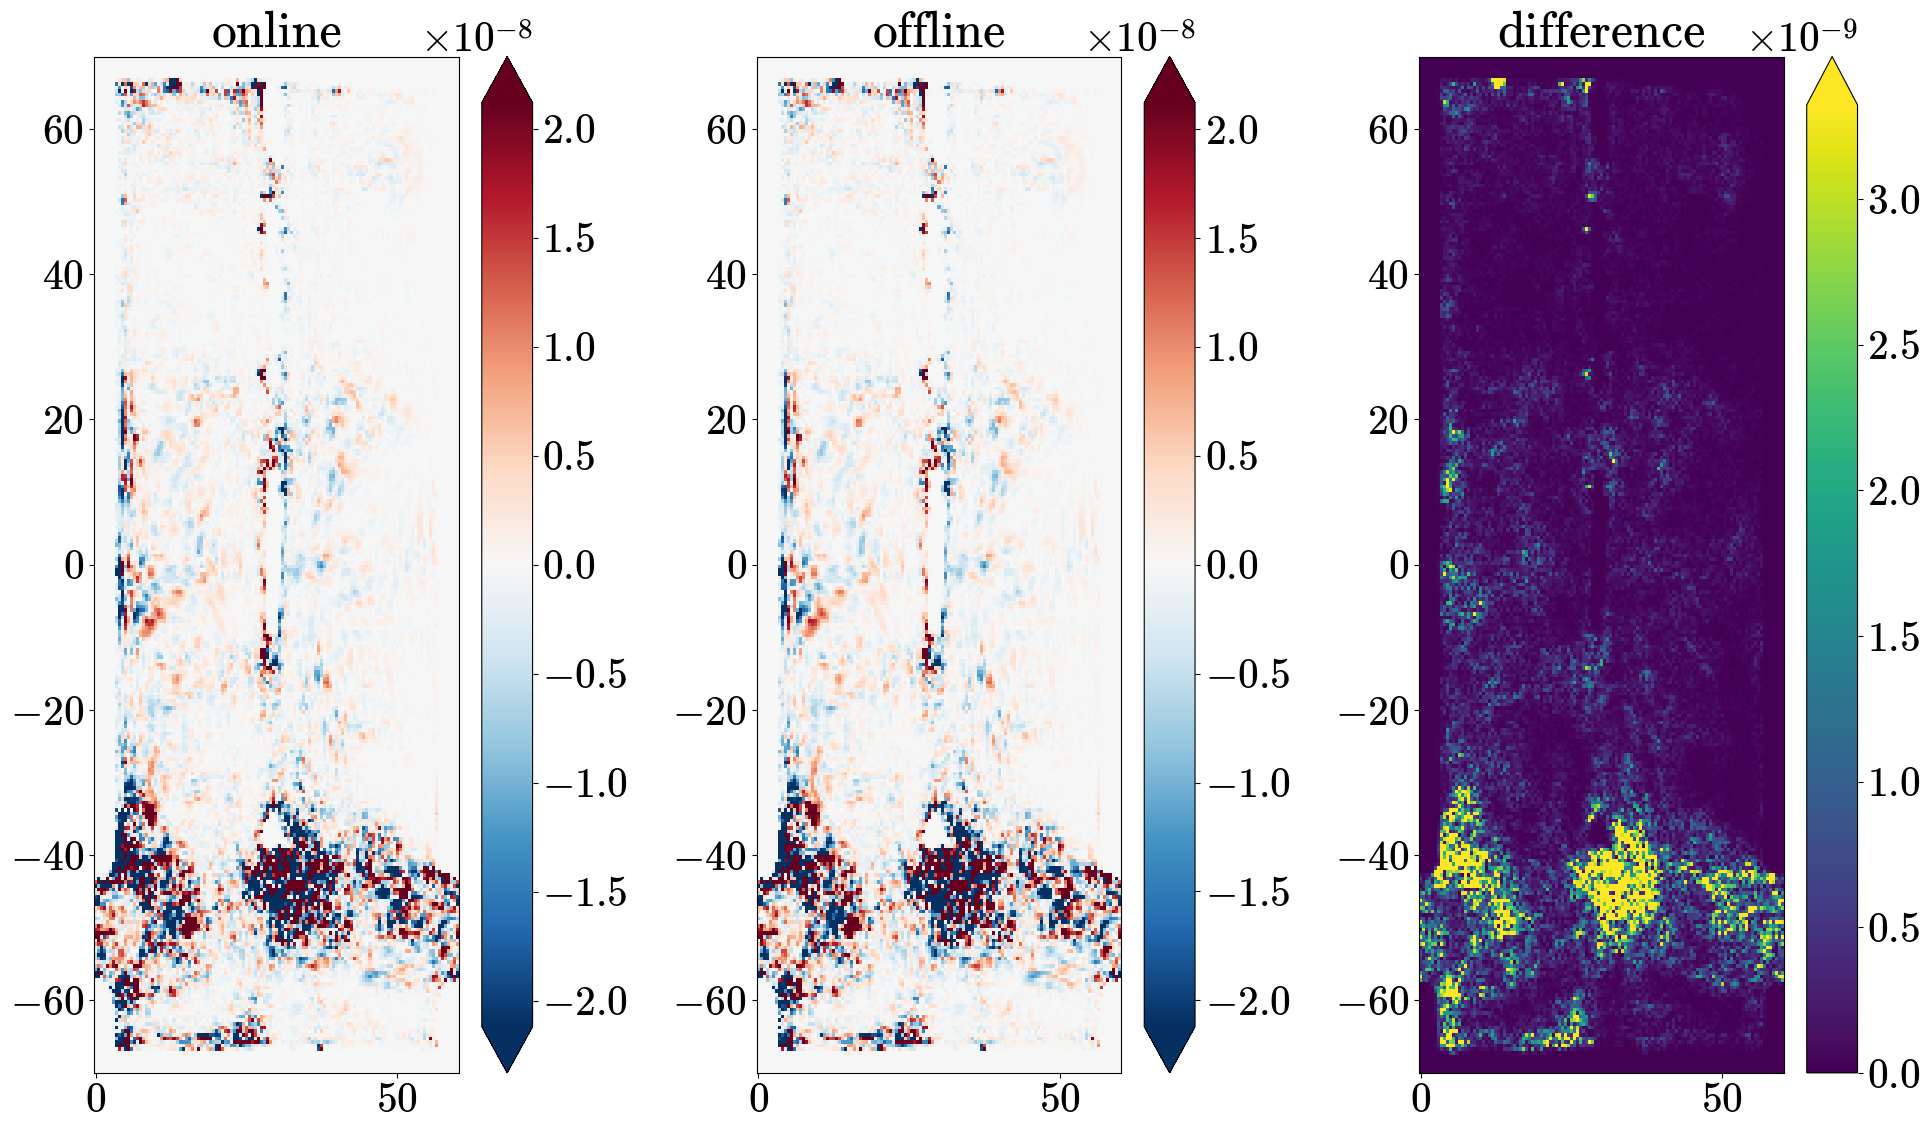

In [13]:
compare(mom.ZB2020u, Zanna_Bolton(mom,param,0, R_diss=-1.0)['ZB2020u'], param.wet_u, zl=11)

Relative Error: 0.0015202268030229847
Nans: 0


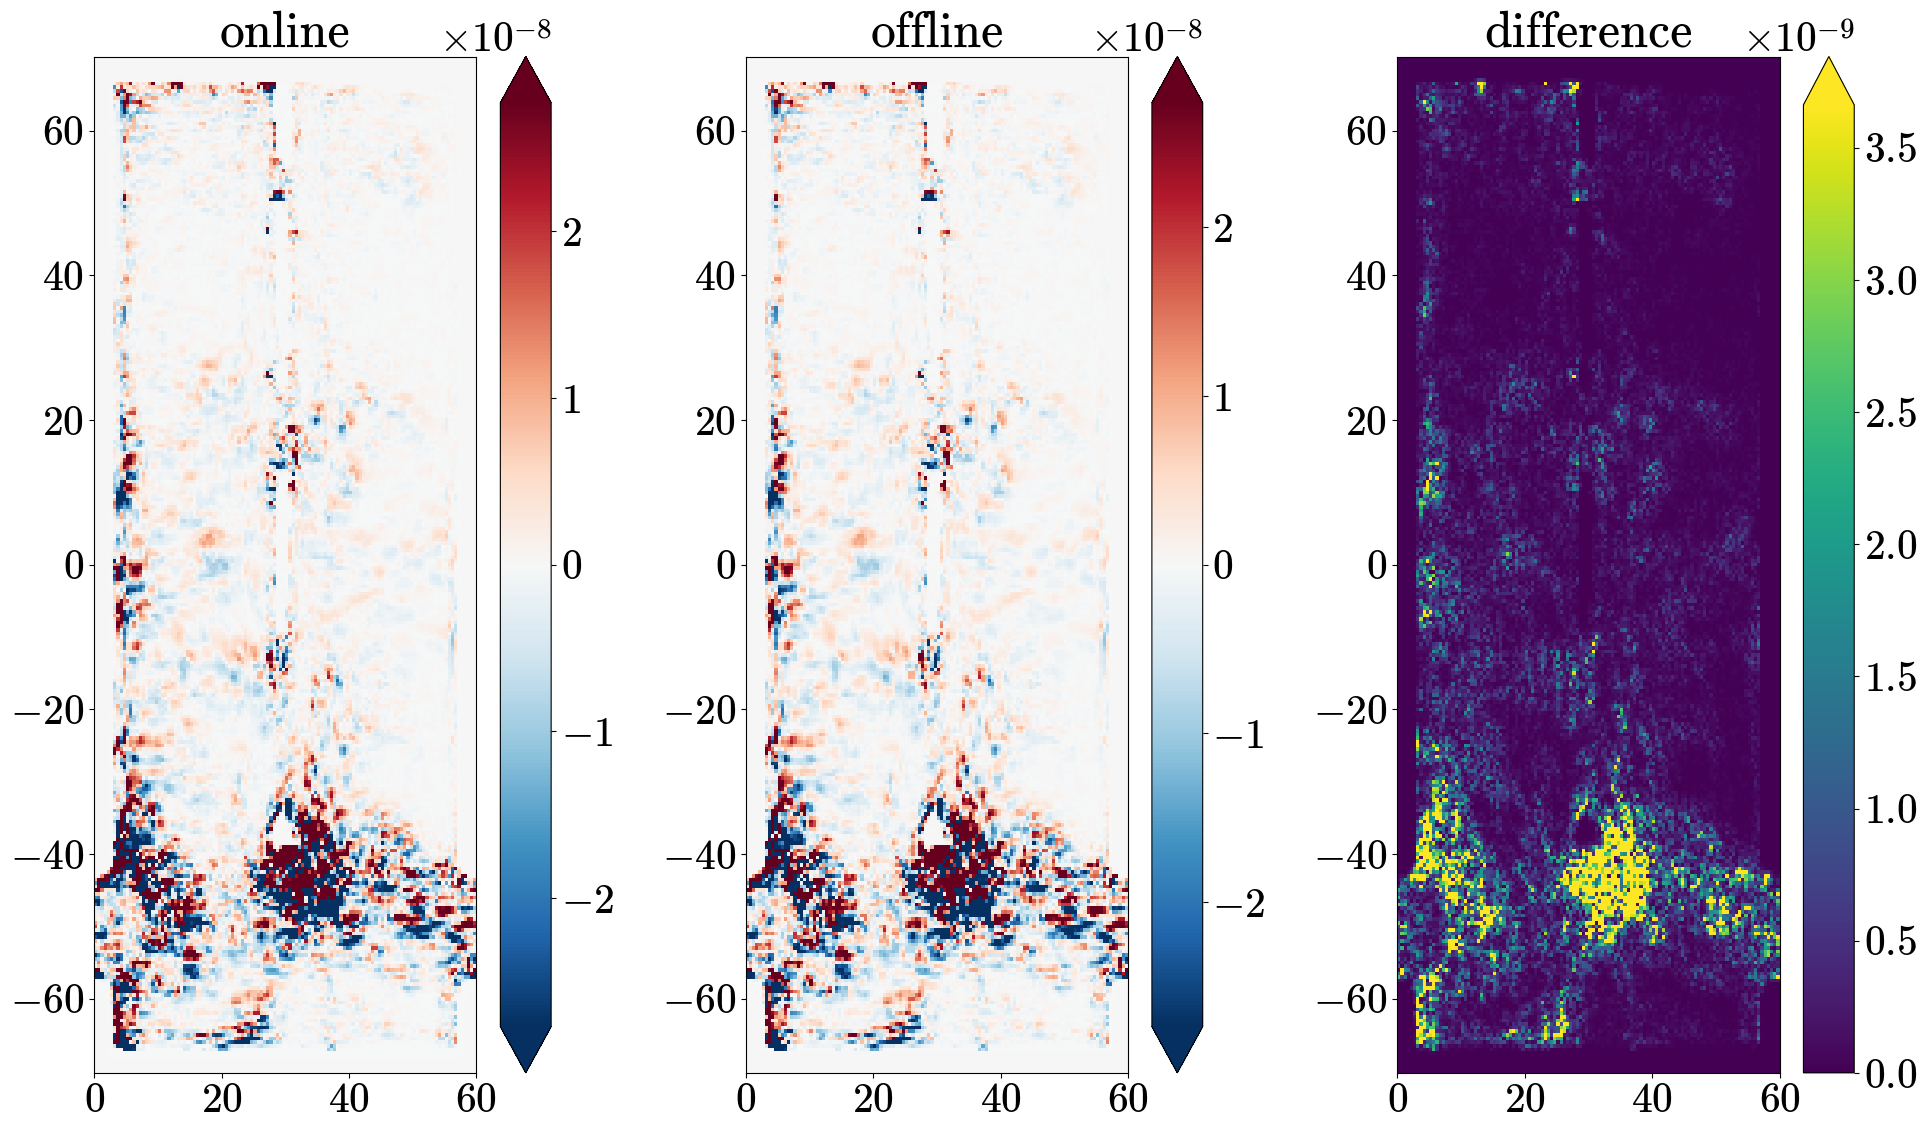

In [14]:
compare(mom.ZB2020v, Zanna_Bolton(mom,param,0, R_diss=-1.0)['ZB2020v'], param.wet_v, zl=11)

Relative Error: 0.0008198839989375709
Nans: 0


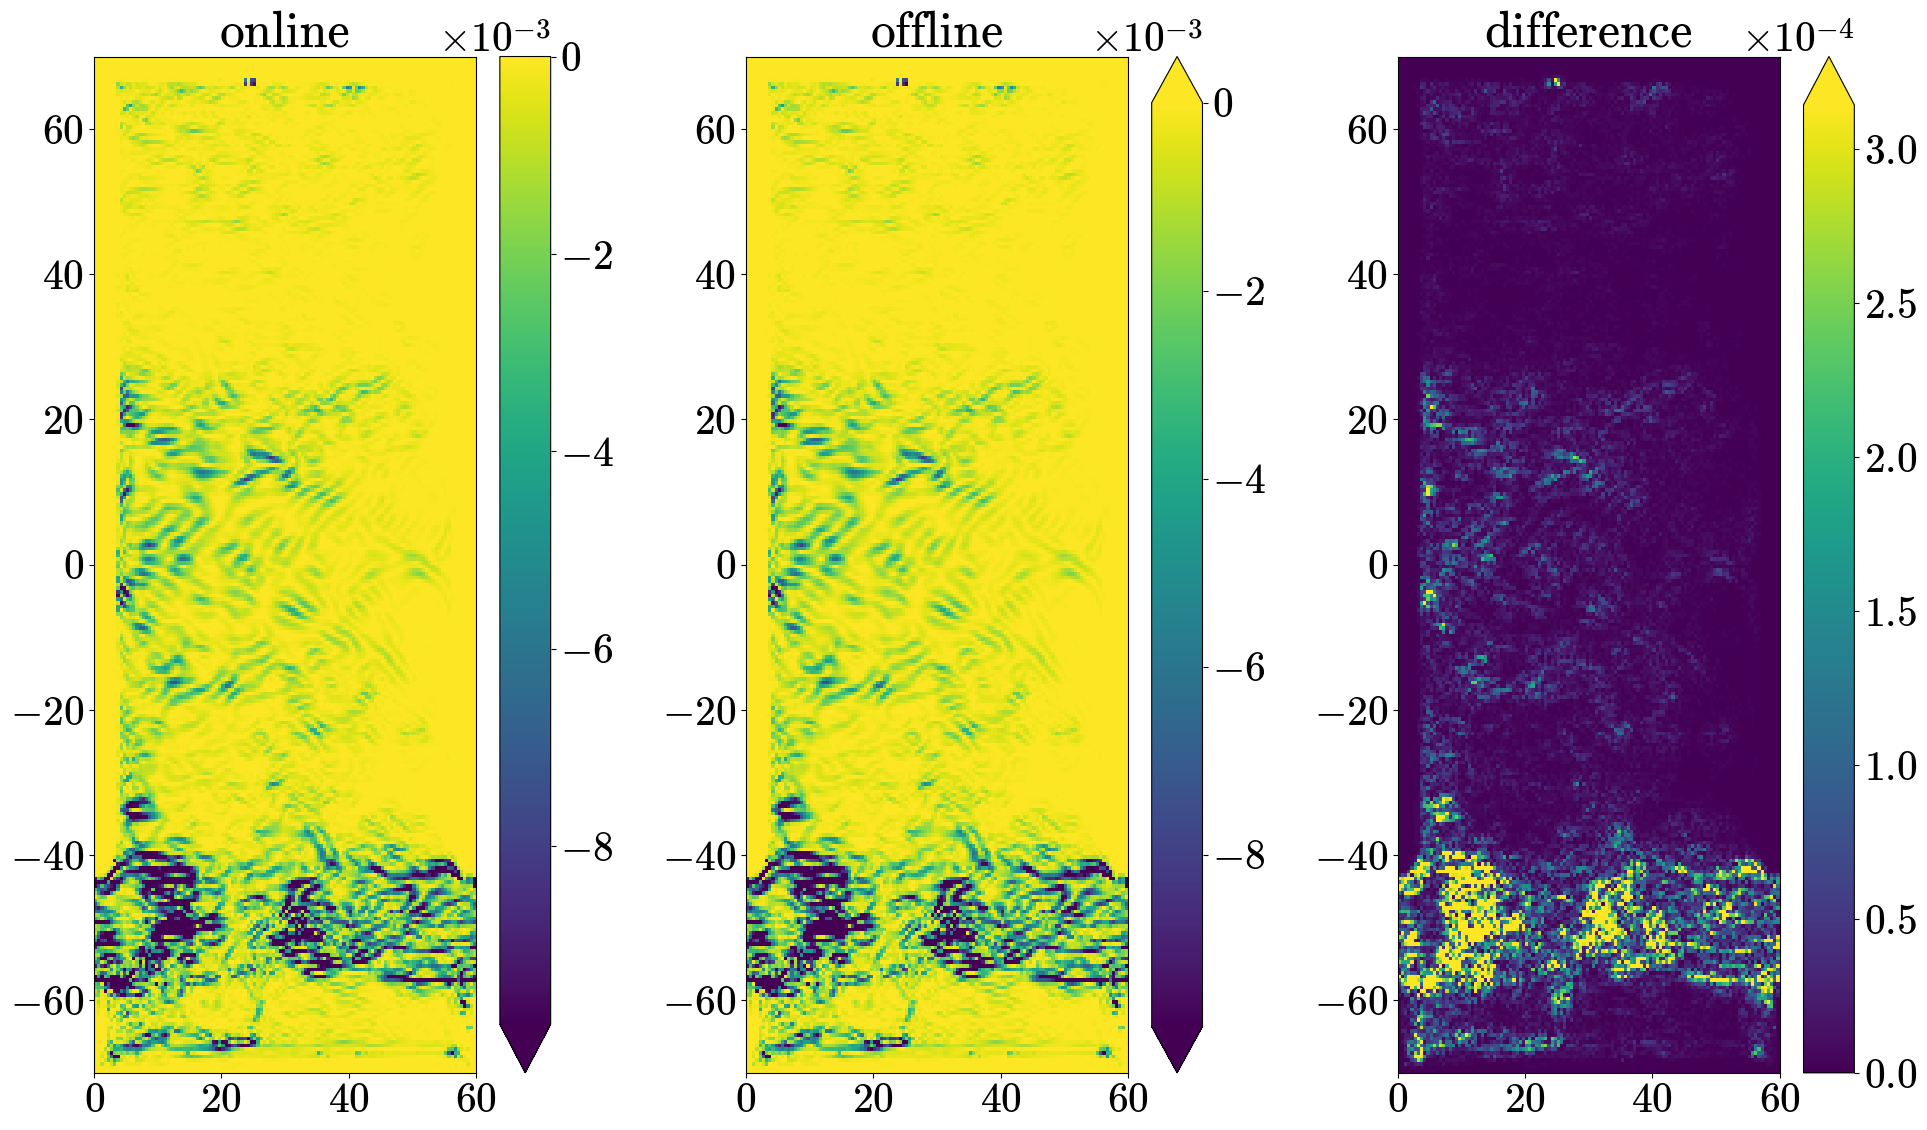

In [15]:
compare(mom.Txx, Zanna_Bolton(mom,param,0, R_diss=-1.0)['Txx'], param.wet, zl=8)

Relative Error: 0.0007338920876193982
Nans: 0


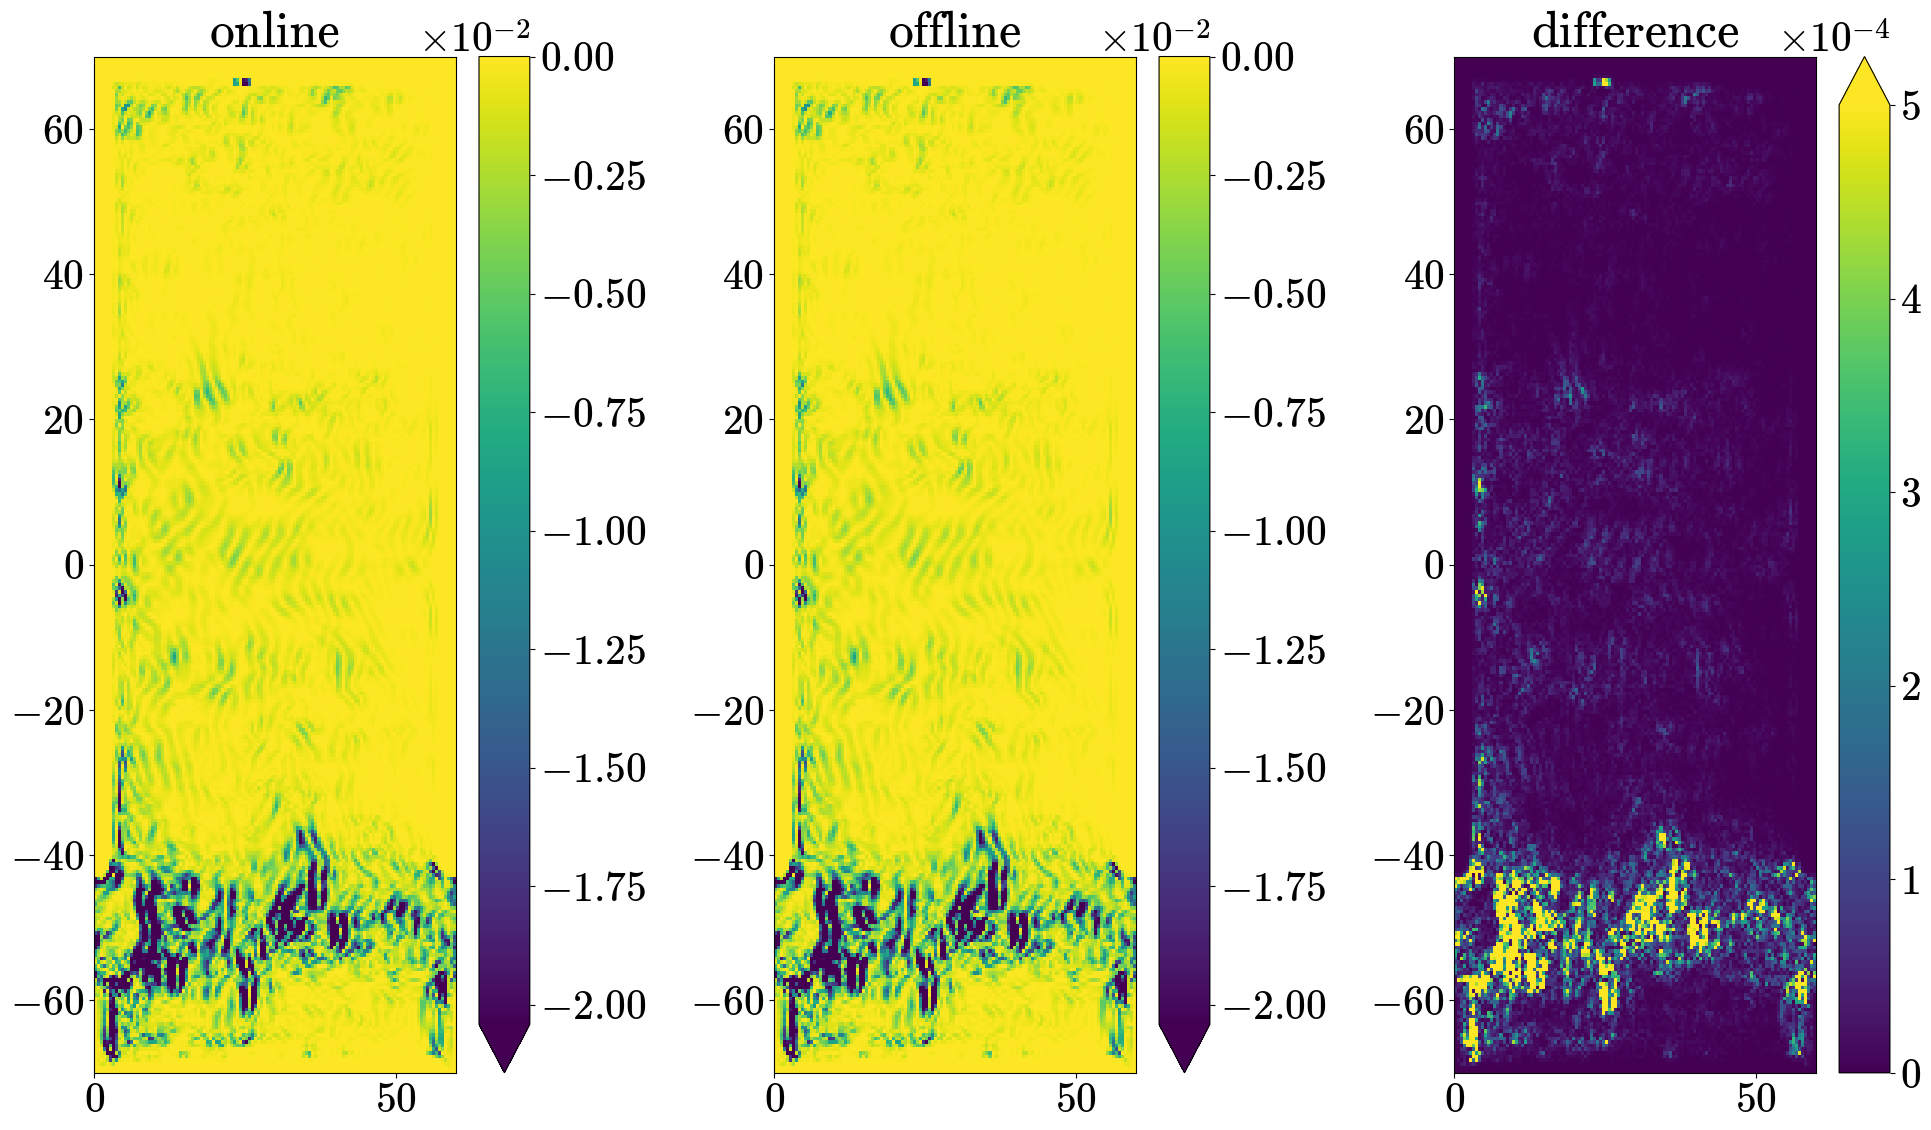

In [16]:
compare(mom.Tyy, Zanna_Bolton(mom,param,0, R_diss=-1.0)['Tyy'], param.wet, zl=8)

Relative Error: 0.0005838706434536475
Nans: 0


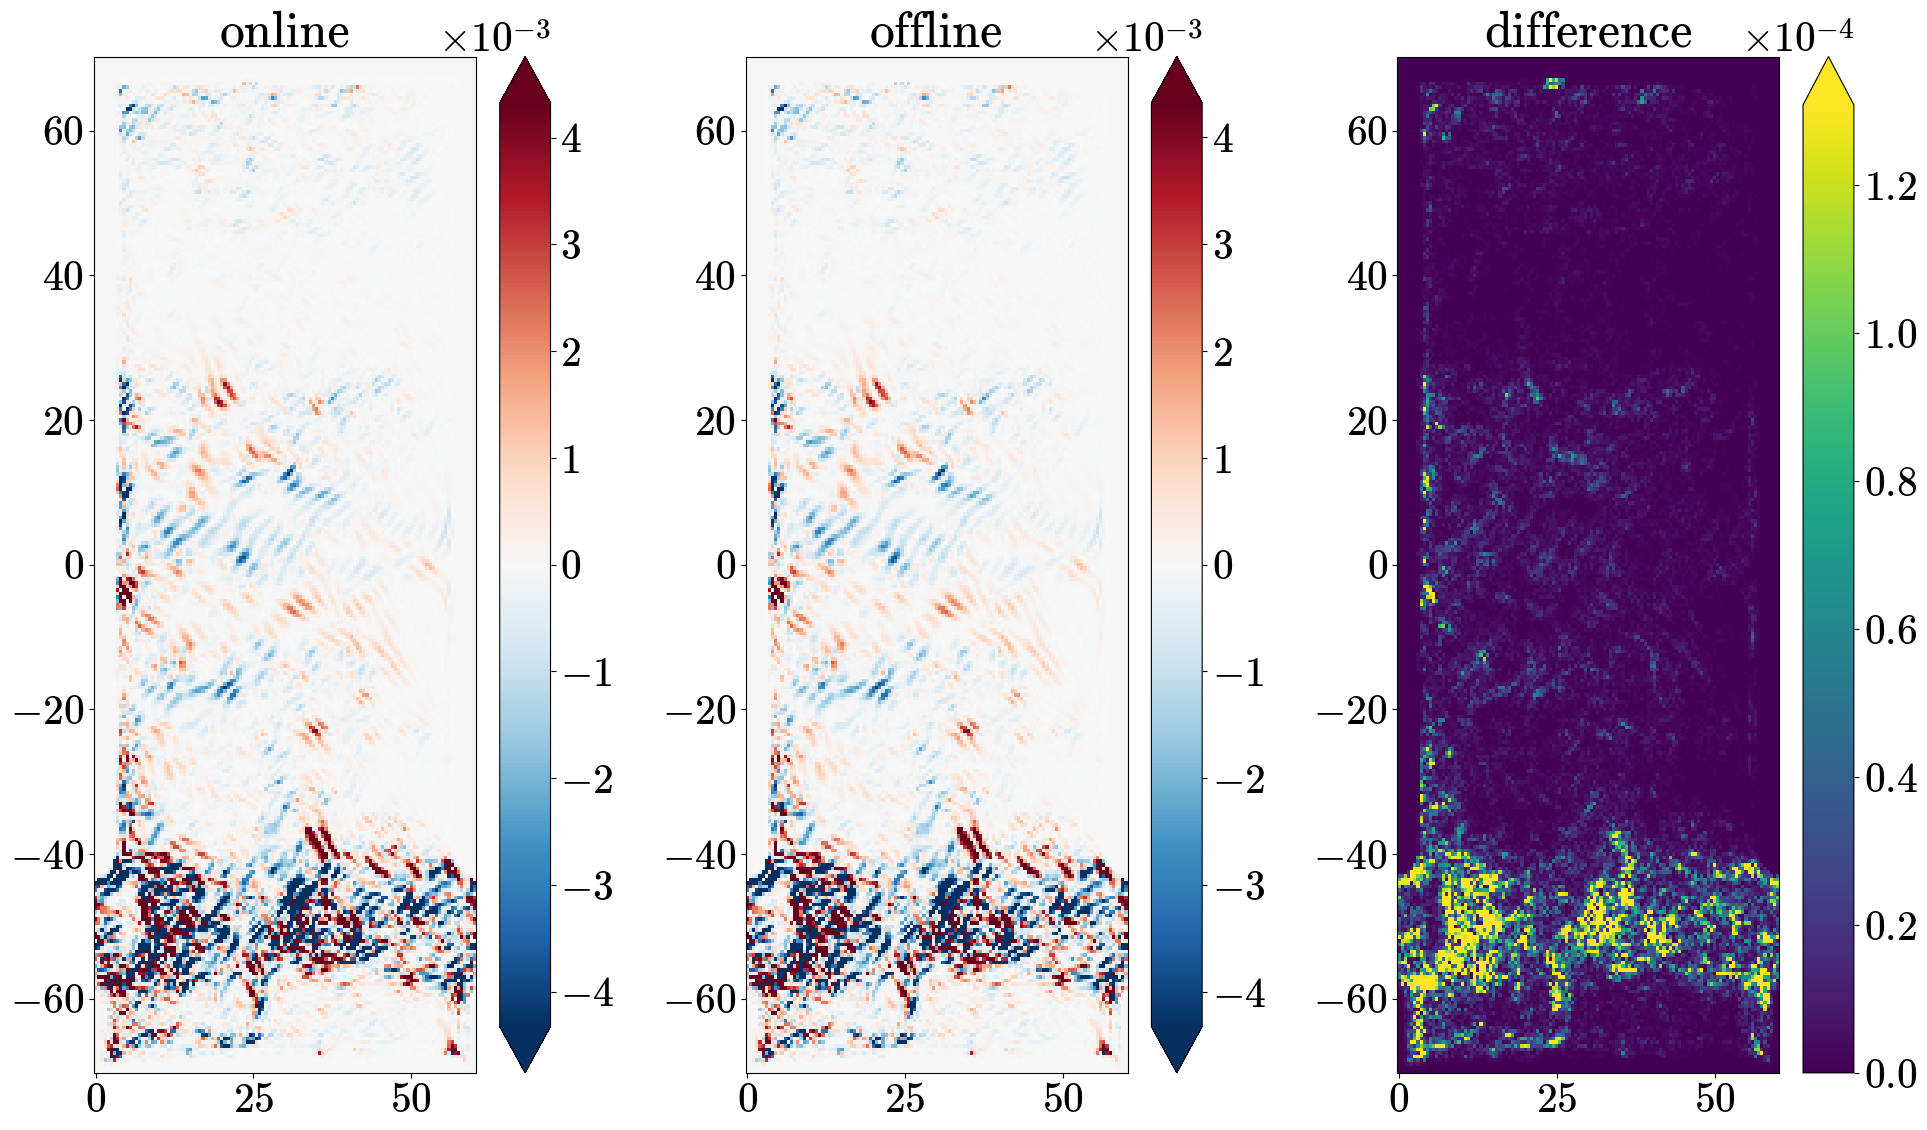

In [17]:
compare(mom.Txy, Zanna_Bolton(mom,param,0, R_diss=-1.0)['Txy'], param.wet_c, zl=8)

In [18]:
def R2(target, pred, mask, dims=None):
    return 1 - ((target*mask-pred*mask)**2).sum(dim=dims) / ((target*mask)**2).sum(dim=dims)

R2, zonal= 0.9966501992813928
R2, meridional= 0.9984666373425068


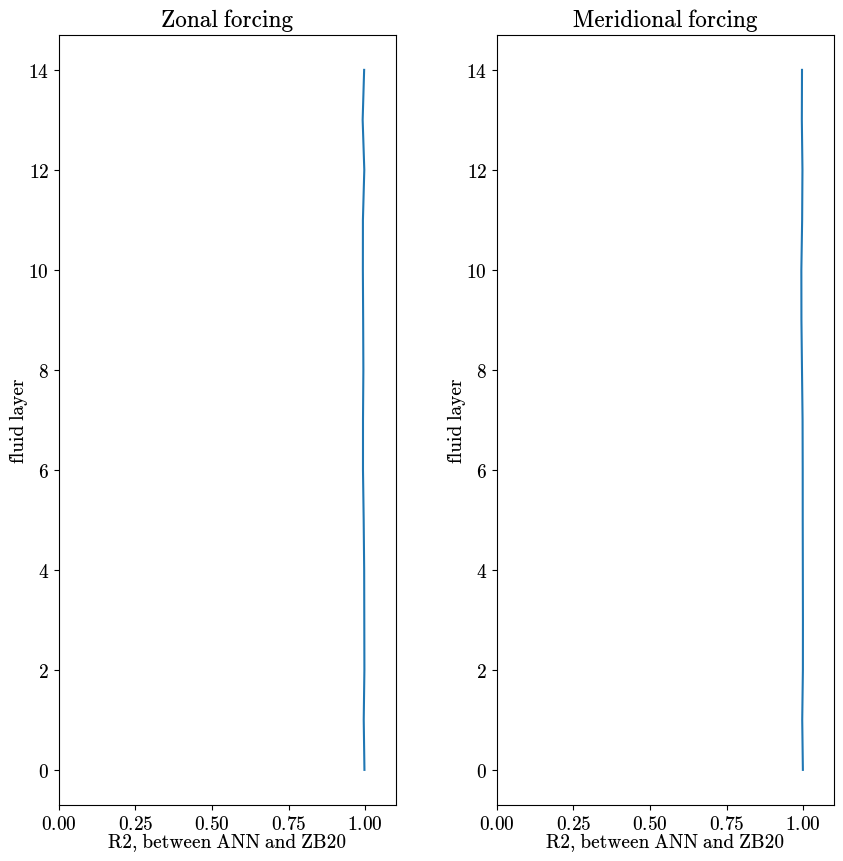

In [19]:
default_rcParams()
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
offline = Zanna_Bolton(mom,param,0, R_diss=-1.0)['ZB2020u']
online = mom.ZB2020u
R2(online, offline, param.wet_u, dims=['xq', 'yh']).drop_vars('zl').plot(y='zl')
plt.xlim([0,1.1])
plt.xlabel('R2, between ANN and ZB20')
plt.ylabel('fluid layer')
plt.title('Zonal forcing')
print('R2, zonal=', float(R2(online, offline, param.wet_u)))

plt.subplot(1,2,2)
offline = Zanna_Bolton(mom,param,0, R_diss=-1.0)['ZB2020v']
online = mom.ZB2020v
R2(online, offline, param.wet_v, dims=['xh', 'yq']).drop_vars('zl').plot(y='zl')
plt.xlim([0,1.1])
plt.xlabel('R2, between ANN and ZB20')
plt.ylabel('fluid layer')
plt.title('Meridional forcing')

print('R2, meridional=', float(R2(online, offline, param.wet_v)))

# Comparison to new code

In [15]:
from helpers.computational_tools import StateFunctions

In [16]:
folder = '/scratch/pp2681/mom6/regression_tests/profiling-NW2'
param = xr.open_dataset(f'{folder}/ocean_geometry.nc').rename({'lonq': 'xq', 'latq': 'yq', 'lonh': 'xh', 'lath': 'yh'})
static = xr.open_dataset(f'{folder}/static.nc', decode_times=False)
param = xr.merge([param, static])
mom = xr.open_dataset(f'{folder}/mom_00030001.nc', decode_times=False).squeeze()
for key in mom.variables:
    mom[key] = mom[key].fillna(1e+20)

In [17]:
mom['h'] = 1 + mom['h'] * 0

In [18]:
def sel(x):
    if 'xq' in x.dims:
        x = x.isel(xq=slice(1,None))
    if 'yq' in x.dims:
        x = x.isel(yq=slice(1,None))
    return x

In [19]:
exp = StateFunctions(sel(mom), sel(param))

Relative Error: 0.0
Nans: 0


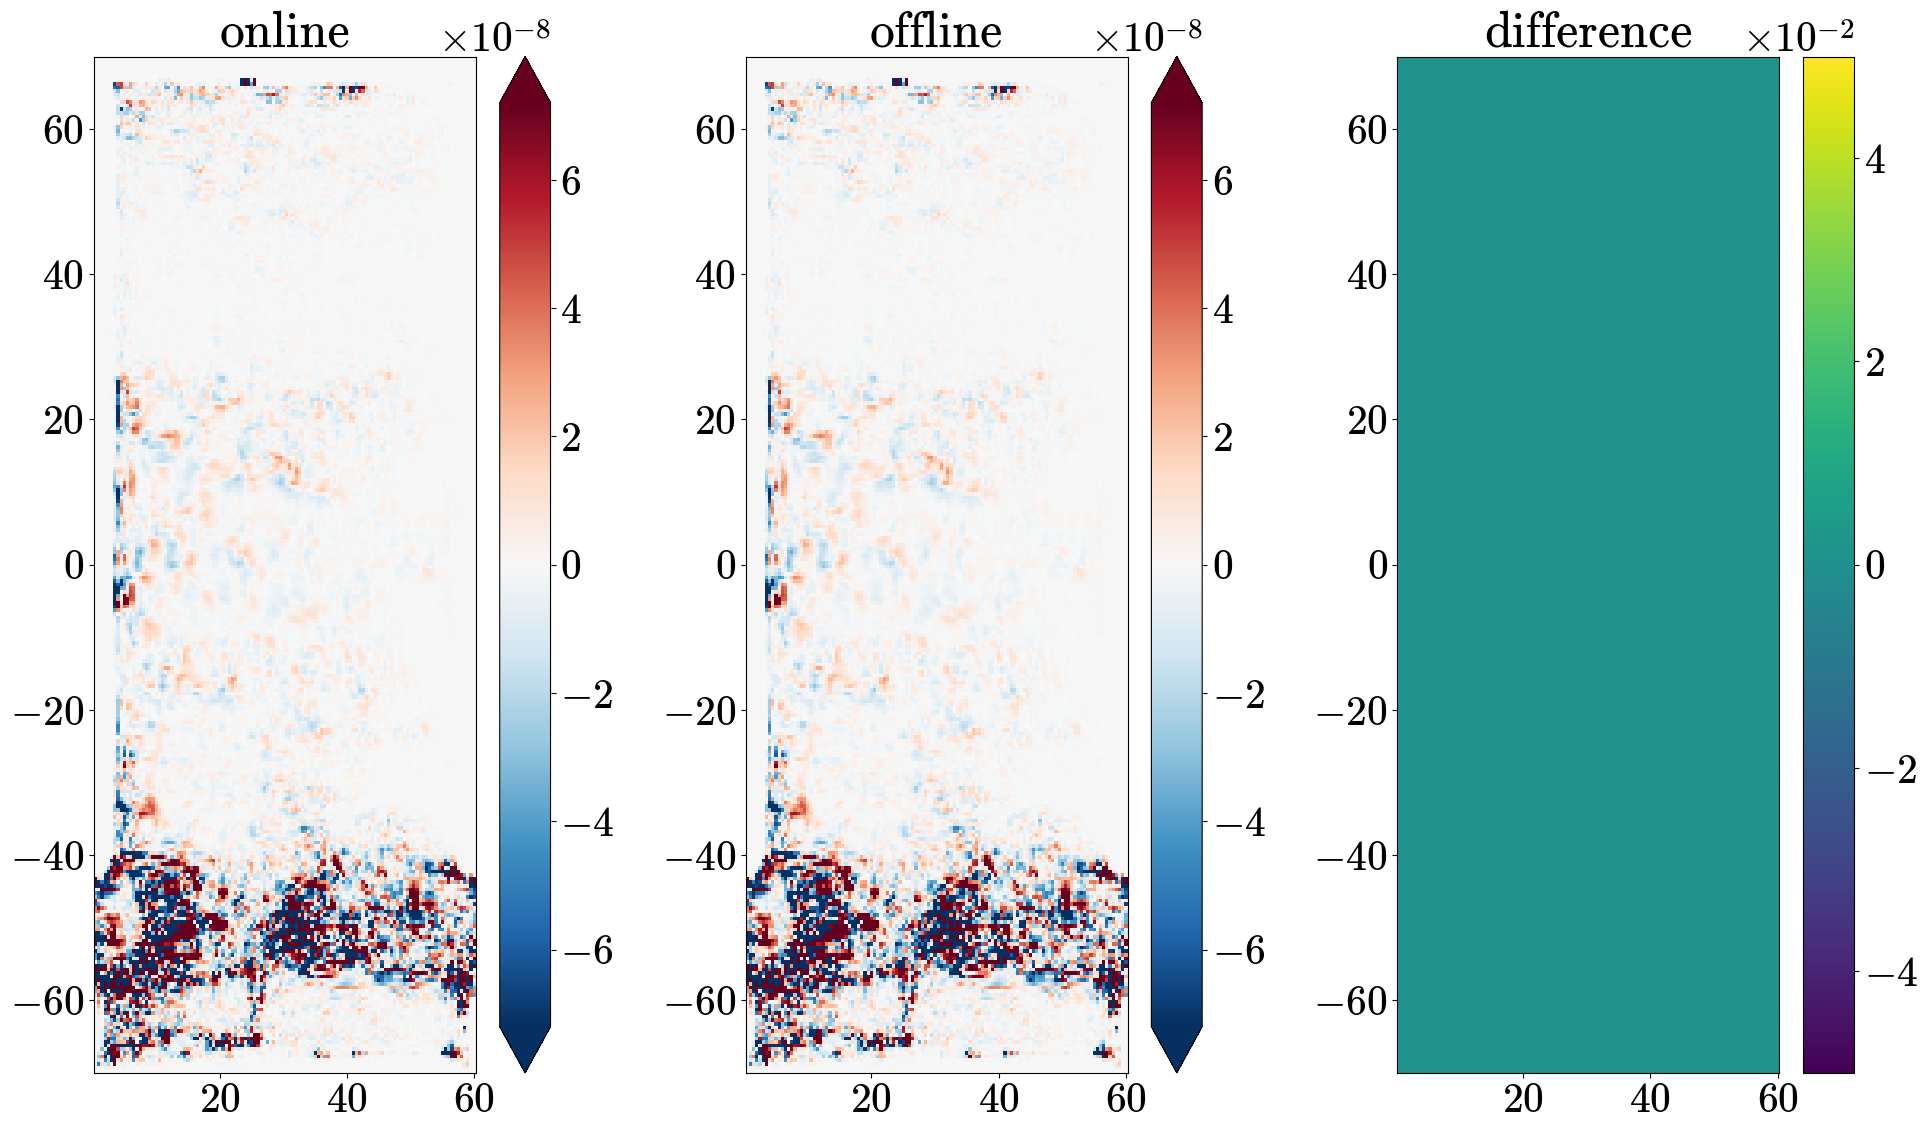

In [20]:
compare(exp.ZB20()['ZB2020u'], sel(Zanna_Bolton(mom,param,0, R_diss=-1.0)['ZB2020u']), sel(param.wet_u), zl=8)

Relative Error: 0.0
Nans: 0


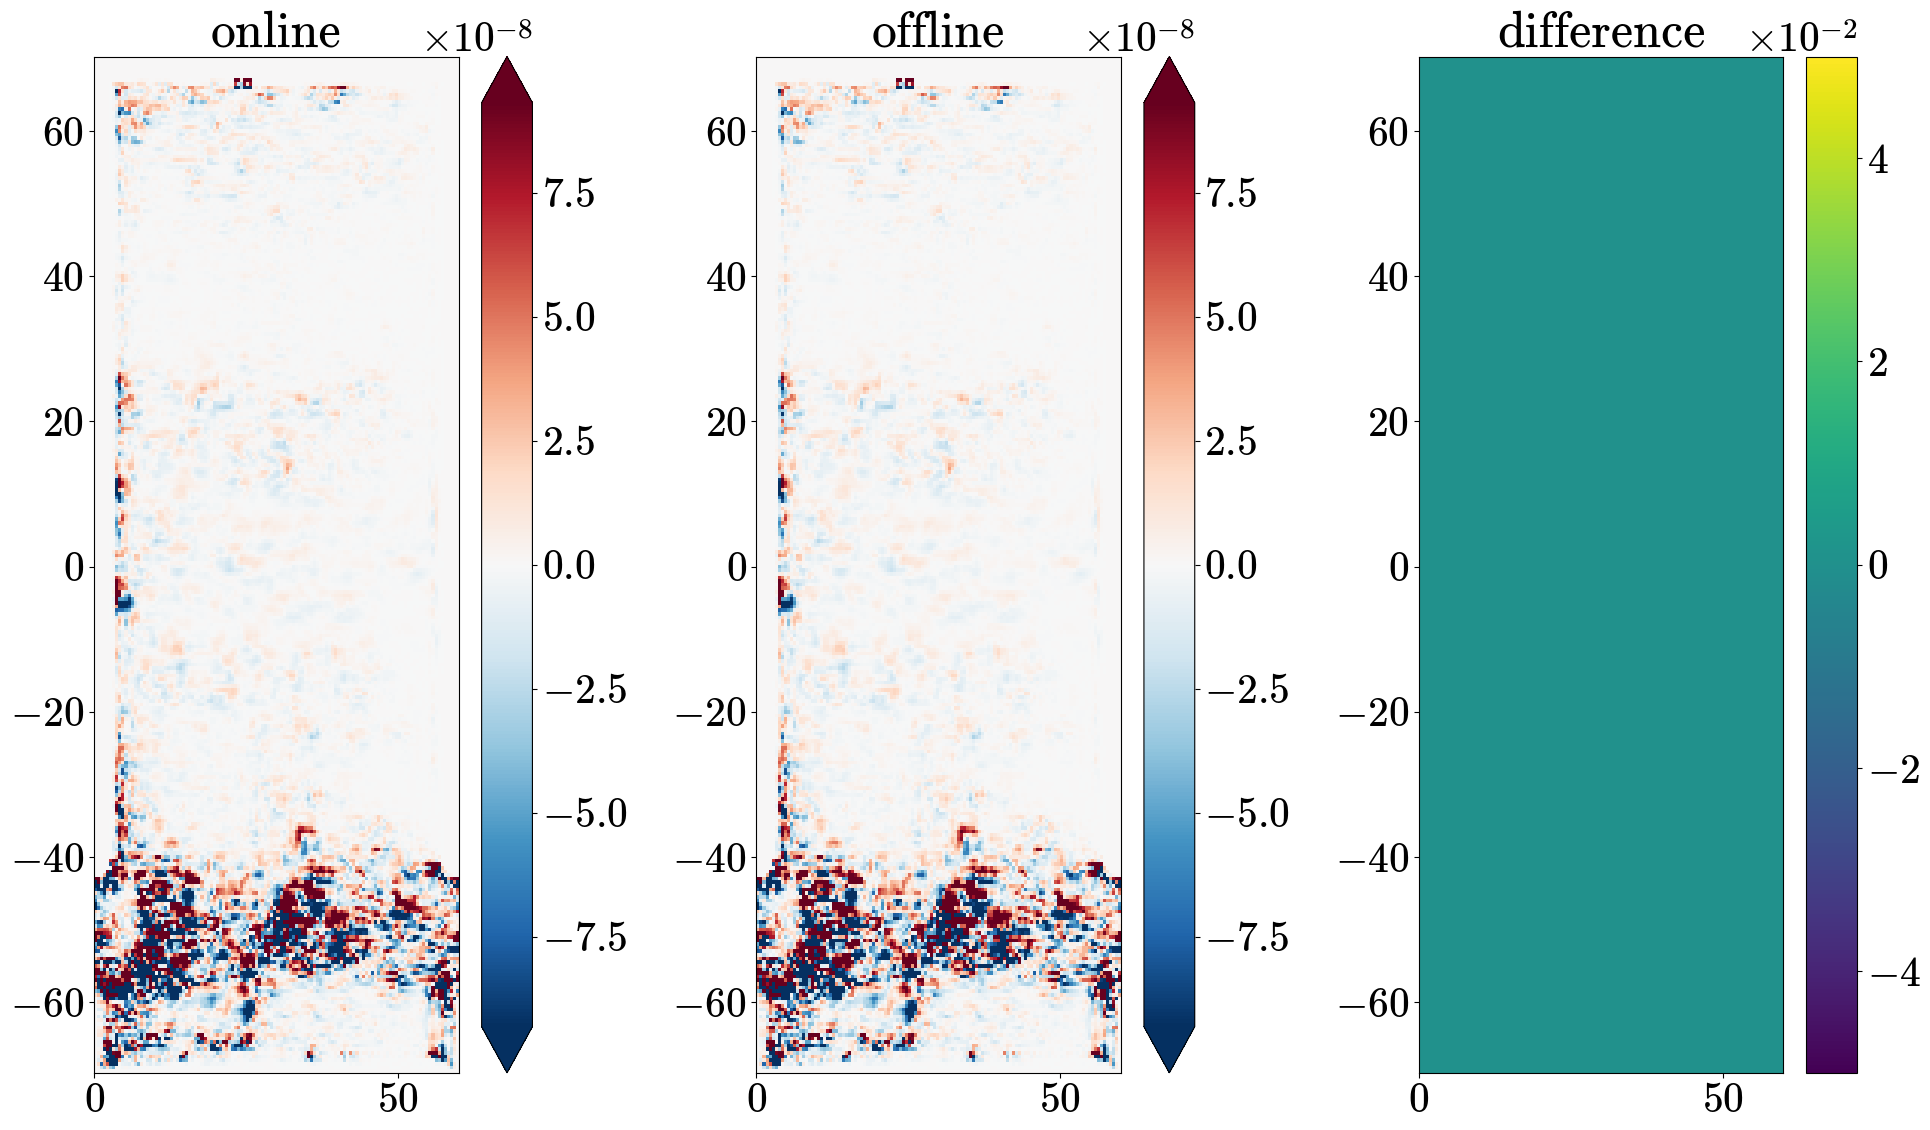

In [21]:
compare(exp.ZB20()['ZB2020v'], sel(Zanna_Bolton(mom,param,0, R_diss=-1.0)['ZB2020v']), sel(param.wet_v), zl=8)

# Comparison to new code, advection

In [22]:
data = xr.open_dataset('../Old_code_advection.nc')

In [23]:
param = xr.open_dataset('/scratch/pp2681/mom6/Feb2022/bare/R8/output/ocean_geometry.nc').rename(
                {'latq': 'yq', 'lonq': 'xq', 'lath': 'yh', 'lonh': 'xh'} # change coordinates notation as in other files
            )

In [24]:
param['wet_u'] = param.dxCu * 0 + 1
param['wet_v'] = param.dxCv * 0 + 1
param['wet_c'] = param.dxBu * 0 + 1

In [25]:
exp = StateFunctions(sel(data), sel(param))

Relative Error: 8.730912008692997e-32
Nans: 0


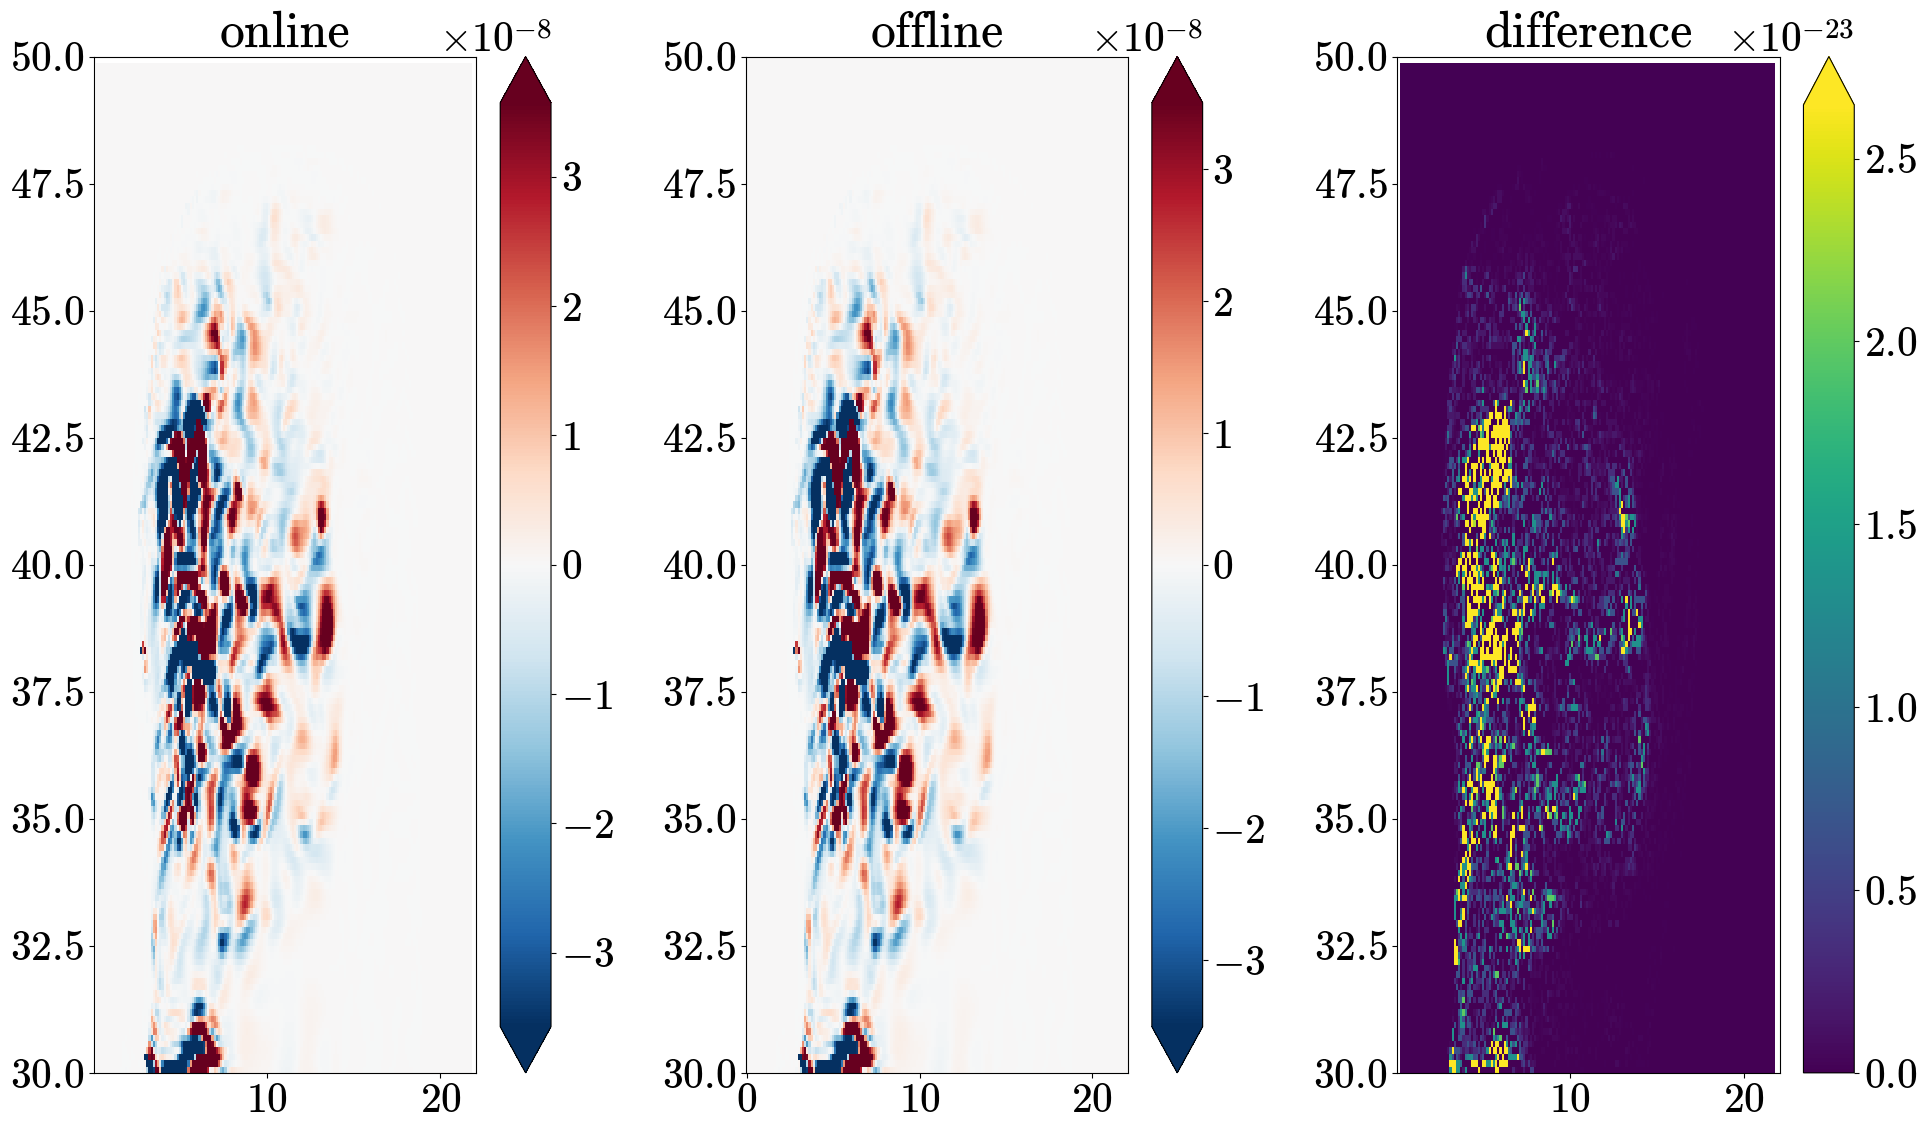

In [26]:
compare(exp.advection()[0], data.advx, param.wet_u)

Relative Error: 3.661791845729072e-32
Nans: 0


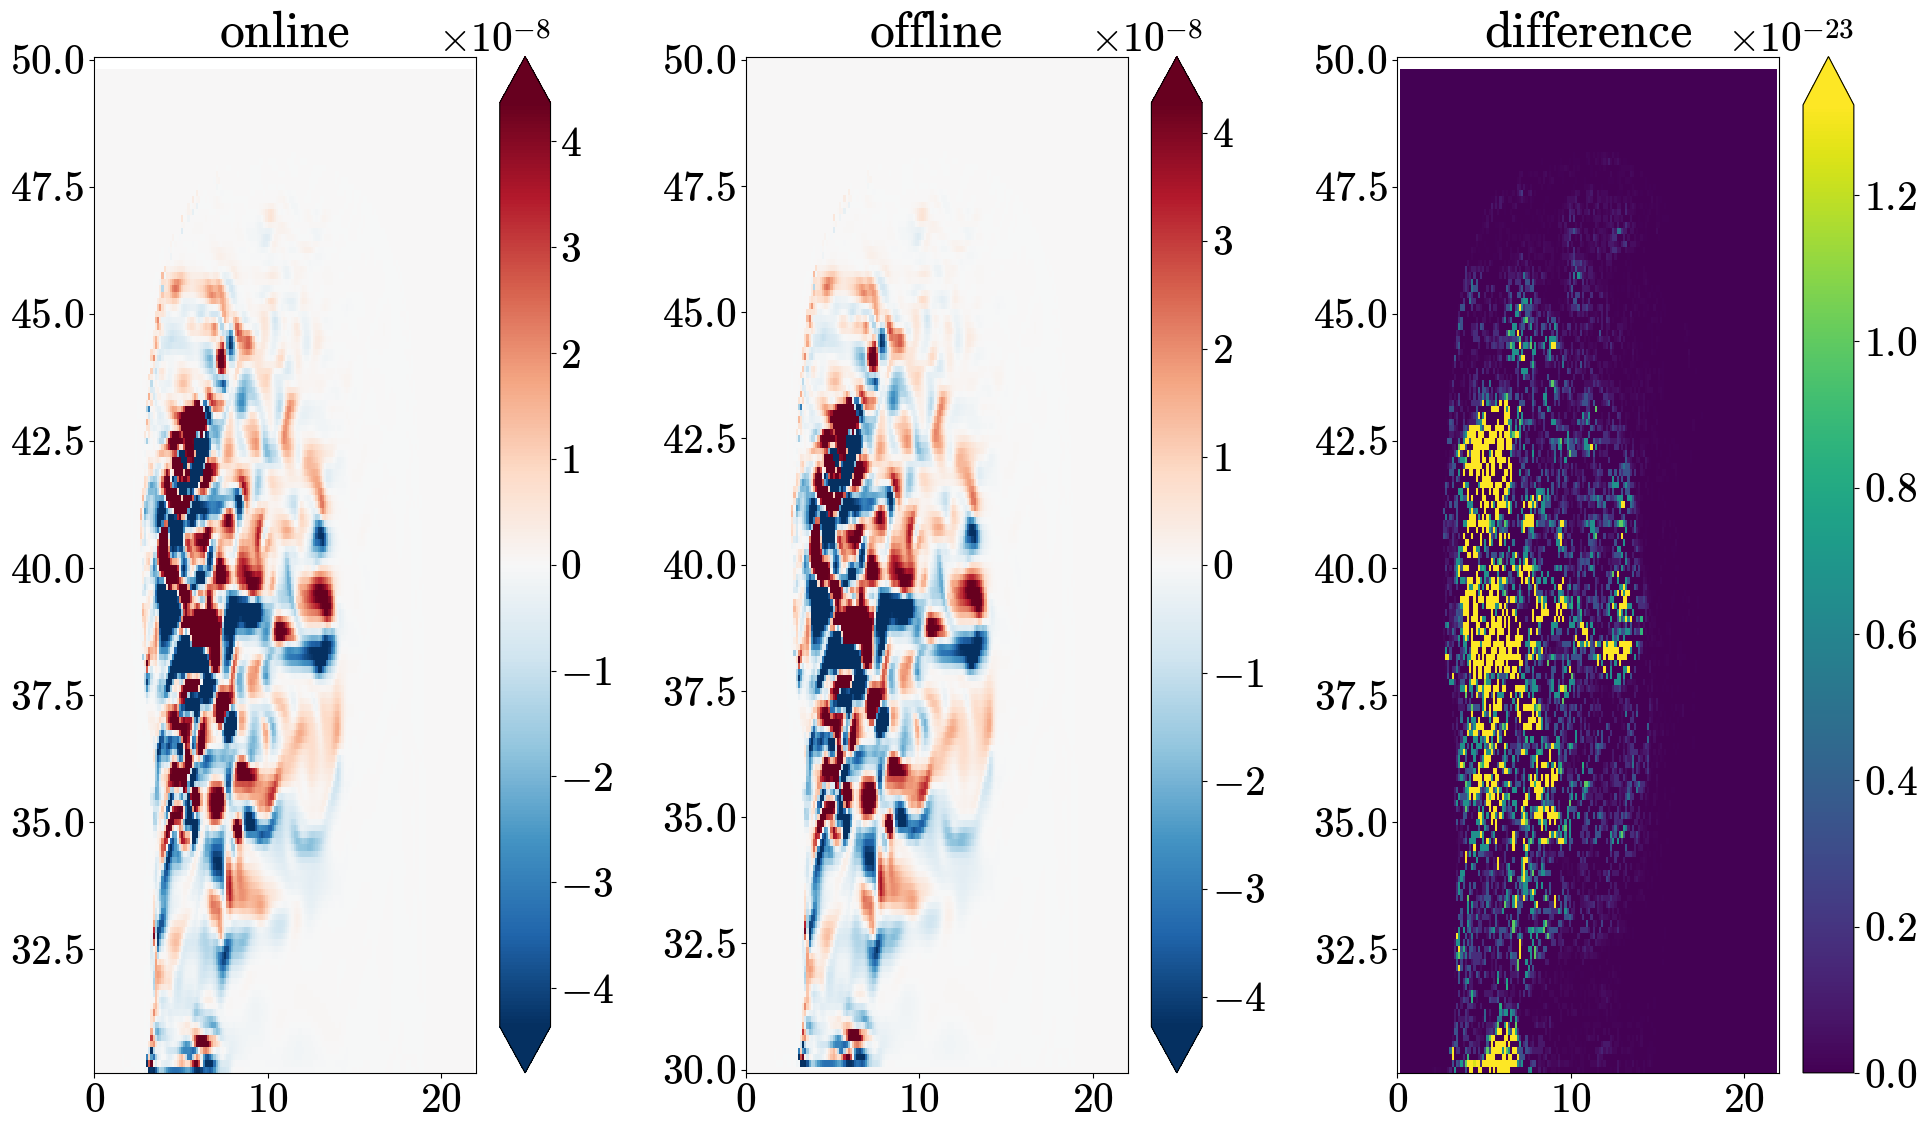

In [27]:
compare(exp.advection()[1], data.advy, param.wet_v)